# Анализ временного ряда tovar_moving

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('tovar_moving.csv', index_col=0, parse_dates=True)
# Принудительно задаём частоту, если индекс DatetimeIndex
if isinstance(df.index, pd.DatetimeIndex):
    freq = pd.infer_freq(df.index)
    if freq is not None:
        df.index = pd.DatetimeIndex(df.index, freq=freq)
series = df.iloc[:, 0]
train, test = series.iloc[:-1], series.iloc[-1]
print(f"Тестовое значение: {test}")

Тестовое значение: 423846.0


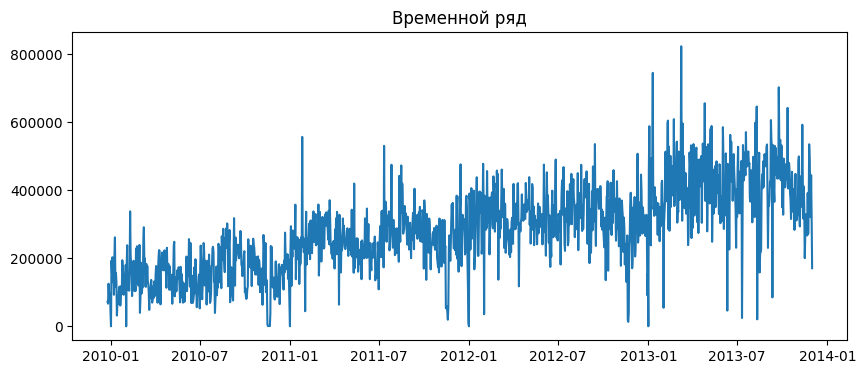

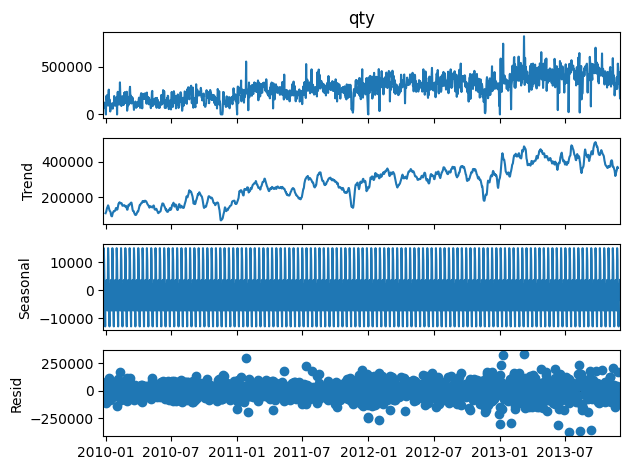

In [15]:
# 2. Анализ тренда и сезонности
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(10,4))
plt.plot(train)
plt.title('Временной ряд')
plt.show()

decomp = seasonal_decompose(train, model='additive', period=12)
decomp.plot();

In [16]:
# 3. Экспоненциальное сглаживание (alpha=0.7)
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train).fit(smoothing_level=0.7, optimized=False)
# Перед прогнозом убеждаемся, что индекс train с freq
if isinstance(train.index, pd.DatetimeIndex) and train.index.freq is None:
    freq = pd.infer_freq(train.index)
    if freq is not None:
        train.index = pd.DatetimeIndex(train.index, freq=freq)
forecast = model.forecast(1).iloc[0]
print(f"Прогноз (эксп. сглаживание): {forecast}")
print(f"Фактическое значение: {test}")

Прогноз (эксп. сглаживание): 225015.5226471296
Фактическое значение: 423846.0


In [17]:
# 4. Проверка на стационарность (тест Дики-Фуллера)
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(train)
print(f"ADF statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

# Определение порядка интегрирования
d = 0
series_diff = train.copy()
while adfuller(series_diff)[1] > 0.05:
    series_diff = series_diff.diff().dropna()
    d += 1
print(f"Порядок интегрирования d: {d}")

ADF statistic: -2.2553026410338
p-value: 0.18678903123416452
Порядок интегрирования d: 1


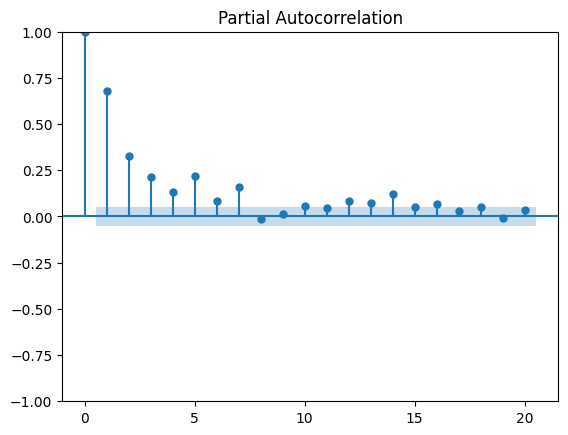

In [18]:
# 5. График частичной автокорреляции (PACF)
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train, lags=20)
plt.show()

In [19]:
# 6. Модель AR и прогноз
from statsmodels.tsa.ar_model import AutoReg
# По PACF выберите порядок p (например, p=1 или p=2)
p = 1  # замените на ваш порядок после анализа PACF
# Устанавливаем freq для train, если возможно
if isinstance(train.index, pd.DatetimeIndex) and train.index.freq is None:
    freq = pd.infer_freq(train.index)
    if freq is not None:
        train.index = pd.DatetimeIndex(train.index, freq=freq)
ar_model = AutoReg(train, lags=p).fit()
ar_forecast = ar_model.predict(start=len(train), end=len(train))
print(f"Прогноз (AR): {ar_forecast.values[0]}")

Прогноз (AR): 205974.6476910523


In [20]:
# 7. Сравнение результатов
print(f"Фактическое значение: {test}")
print(f"Эксп. сглаживание: {forecast}")
print(f"AR модель: {ar_forecast.values[0]}")

Фактическое значение: 423846.0
Эксп. сглаживание: 225015.5226471296
AR модель: 205974.6476910523
